In [1]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [2]:
using ReactiveMP, KernelFunctions, Distributions, LinearAlgebra,GraphPPL, Rocket,Plots
using Revise 
include("utils_gp2.jl")
pgfplotsx()
import StatsFuns: log2π

In [125]:
#I reduced the number of samples 
xmin, xmax = -3, 3  # Bounds of the data
N = 70# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=200));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

In [188]:
# test new thing
@model function gpprocess(n,kernelfunc,meanfunc,train,test)
    y = datavar(Float64,n)
    x = randomprocess(test,train)
    ### change here 
    θ = randomvar() 
    #θ ~ GammaShapeRate(.01, .01)
    θ ~ NormalMeanVariance(3.5, .1)
    x ~ GaussianProcess(meanfunc,kernelfunc, θ)
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i,nothing,nothing,nothing)}
    end
    return x, γ, θ, y  
end

In [189]:
function Distributions.entropy(pm::PointMass{F}) where {F <: Function}
    return ReactiveMP.InfCountingReal(Float64,-1)
end

function Distributions.entropy(pm::PointMass{F}) where {F <: Kernel}
    return ReactiveMP.InfCountingReal(Float64,-1)
end

###changed 
@average_energy GaussianProcess (q_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_θ::Any) = begin
    q_out.finitemarginal
    return -entropy(q_out.finitemarginal)
end
############

@average_energy NormalMeanPrecision (q_out::Any, q_μ::GaussianProcess, q_τ::Any,meta::ProcessMeta) = begin
    m_right, cov_right = mean_cov(q_μ.finitemarginal)
    kernelf = q_μ.kernelfunction
    meanf   = q_μ.meanfunction
    test    = q_μ.testinput
    train   = q_μ.traininput
    μ_mean, μ_var = predMVN_fast(q_μ,test,[train[meta.index]],m_right)
    μ_var = clamp(μ_var[1],1e-8,huge)
    μ_mean = μ_mean[1]
    out_mean, out_var = mean_var(q_out)
    return (log2π - mean(log, q_τ) + mean(q_τ) * (μ_var + out_var + abs2(μ_mean - out_mean))) / 2
end

function ReactiveMP.entropy(p::GaussianProcess)
    return ReactiveMP.entropy(p.finitemarginal)
end

@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::PointMass, q_τ::GammaShapeRate, meta::ProcessMeta) = begin 
    return @call_rule NormalMeanPrecision(:μ, Marginalisation) (q_out=q_out,q_τ=q_τ,meta=nothing)
end
# @rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass) = begin 
#     return GaussianProcess(q_meanfunc.point,q_kernelfunc.point,nothing,nothing,nothing,nothing)
# end

In [190]:
kernel_func =  Matern52Kernel() 
meanfunc   = (x) -> 0.0;

In [191]:
# This is the product function that computes the product of messages for GP node.
# function ReactiveMP.messages_prod_fn(process::RandomProcess)
#     test  = process.test_input
#     train = process.train_input
#     # @show fieldnames(typeof(process))
#     return messages -> begin 
#         m_right,cov_right = make_multivariate_message(map(as_message, messages))

#         return Message(MvNormalMeanCovariance(m_right, cov_right), false, false)
#     end
# end

function ReactiveMP.messages_prod_fn(process::RandomProcess)
    return ReactiveMP.marginal_prod_fn(process)
end

function ReactiveMP.marginal_prod_fn(process::RandomProcess)
    test  = process.test_input
    train = process.train_input

    return messages -> begin 
        message_vector = map(ReactiveMP.as_message, messages)
        process_message = getdata(message_vector[1])
        meanf = process_message.meanfunction
        kernelf = process_message.kernelfunction
        likelihood_messages = message_vector[2:end]
        m_right,cov_right = make_multivariate_message(likelihood_messages)
        
        #m, K = predMVN(meta,process_message,train, test, m_right,cov_right)
        m, K= predMVN(kernelf,meanf,train,test,m_right,cov_right) #Ismail code
        Kff = kernelmatrix(kernelf, test, test)
        invKff = cholinv(Kff + K)
        return Marginal(GaussianProcess(meanf,kernelf,MvNormalMeanCovariance(m,K),test,train, invKff),false,false)
    end
end

In [193]:
@constraints function gpconstraints()   
    q(θ) :: PointMass(starting_point = (args...) -> [ 1.5 ])
    q(x,γ,θ) = q(x)q(γ)q(θ)
end

gpconstraints (generic function with 1 method)

In [185]:
#missing rule 
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::GammaShapeRate, ) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, mean(q_θ)) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::PointMass, ) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, mean(q_θ)) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

In [207]:
include("utils_gp2.jl")

predMVN (generic function with 1 method)

In [208]:
nits = 20
iresult = inference(
    model = Model(gpprocess, length(ytrain), kernel_func, meanfunc, xtrain,xtest),
    initmarginals = (γ = vague(GammaShapeRate),θ = PointMass(2.)),
    options = model_options(limit_stack_depth = 500),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    free_energy = true,
    showprogress = true
)


Progress:  10%|█████                                    |  ETA: 0:04:18

Progress:  15%|███████                                  |  ETA: 0:02:48

Progress:  20%|█████████                                |  ETA: 0:02:05

Progress:  25%|███████████                              |  ETA: 0:01:39

Progress:  30%|█████████████                            |  ETA: 0:01:21

Progress:  35%|███████████████                          |  ETA: 0:01:07

Progress:  40%|█████████████████                        |  ETA: 0:00:56

Progress:  45%|███████████████████                      |  ETA: 0:00:49

Progress:  50%|█████████████████████                    |  ETA: 0:00:42

Progress:  55%|███████████████████████                  |  ETA: 0:00:38

Progress:  60%|█████████████████████████                |  ETA: 0:00:32

Progress:  65%|███████████████████████████              |  ETA: 0:00:27

Progress:  70%|█████████████████████████████            |  ETA: 0:00:23

Progress:  75%|███████████████████████████████          |  ETA: 0:00:19

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:15

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:11

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:07

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


Inference results:
-----------------------------------------
Free Energy: Real[85038.4, -5116.13, 1.7635e5, 1.77349e5, 1.75428e5, 171288.0, 1.72149e5, 1.68849e5, 1.65603e5, 1.63735e5, 1.61226e5, 1.58673e5, 1.57007e5, 1.5593e5, 155319.0, 1.55754e5, 1.55405e5, 1.55231e5, 1.55055e5, 1.55052e5]
-----------------------------------------
γ = GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=35.01, b=1.5623854995722874e12...
θ = PointMass{Float64}[PointMass{Float64}(-0.04830160557194898), PointMass{Float64}(...
x = GaussianProcess[GaussianProcess(var"#575#576"(), Matern 5/2 Kernel (metric = Dis...


In [209]:
mean.(iresult.posteriors[:θ])

20-element Vector{Float64}:
 -0.04830160557194898
  3.5911468816231094
  3.660080292738096
  3.5925692443494386
  3.2972415794808905
  3.2674620671575383
  3.045994311624107
  2.8435741112186212
  2.7267002807063556
  2.5802708724083714
  2.4428846369557586
  2.3534594251124346
  2.2971609708704155
  2.272517611114571
  2.2916284748979163
  2.272608139843178
  2.2608424727081493
  2.254593565986222
  2.2541851645328475
  2.2678805333469128

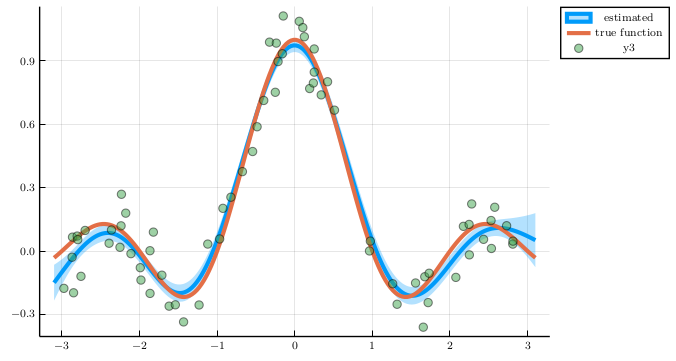

In [210]:
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

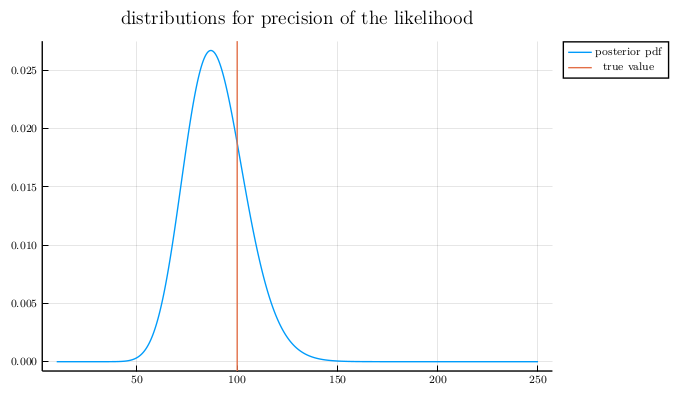

In [202]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)


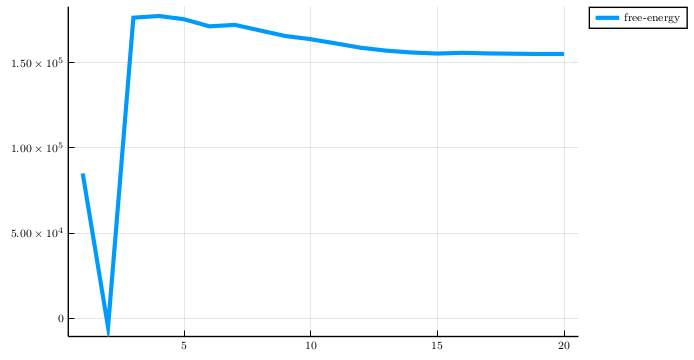

In [203]:
plot(iresult.free_energy,linewidth=3.0,label="free-energy")